In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".25"
import numpy as np
from pathlib import Path
from utils import simulation2d as project
from flowrec import losses
import flowrec.physics_and_derivatives as derivatives
from flowrec.models.cnn import Model
import jax 
import jax.numpy as jnp
from jax import lax
from flowrec._typing import Array, Scalar
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from jax.tree_util import tree_map, Partial
from utils.system import on_which_platform

plt.style.use('utils/ppt.mplstyle')

import logging
# logging.getLogger('fr.utils.decomposition').setLevel(logging.DEBUG)

train_test_split = [600,100,100]
# train_test_split = [600,100,100]
learning_rate = 0.0001
mlp_layers = [] # size of the intermediate layers
cnn_channels = [32,16,3]
cnn_filter = [(3,3)]
dropout_rate = 0.00
regularisation_strength = 0.0000
epochs = 80000
nb_batches = 6
re = 100
data_dir = Path("./local_data/re" + str(re))
dt = 0.0002*625
dx = 12/512
dy = 4/128
sensor_slicing_space = np.s_[::15,::10] # taking points as sensors
weighting = [0.1,0.9] # weighting terms for [physics,sensors]
x_base = 132
(ux,uy,pp) = project.read_data(data_dir,x_base)
# ux = ux[:,:200,:]
# uy = uy[:,:200,:]
# pp = pp[:,:200,:]
x = np.stack([ux,uy,pp],axis=0)
######### delete last rows
x = x[:,:,:250,:]



In [2]:
derivative1 = derivatives.derivative1
derivative2 = derivatives.derivative2

In [3]:
x.shape

(3, 800, 250, 129)

In [4]:
x_mean = np.mean(x,axis=1)
x_fluc = np.swapaxes(x,0,1) - x_mean
print(np.allclose(x_mean+x_fluc,np.swapaxes(x,0,1)))
print(x_mean.shape, x_fluc.shape)

True
(3, 250, 129) (800, 3, 250, 129)


# RANS

RANS divergence

In [5]:
dum_dx = derivatives.derivative1(x_mean[0,...],dx,0)
dvm_dy = derivatives.derivative1(x_mean[1,...],dy,1)

2.8011194e-05


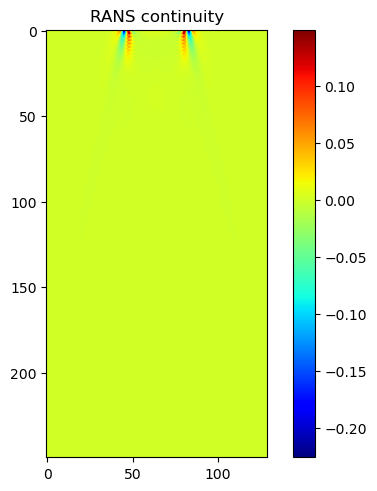

In [6]:
rans_div = dum_dx + dvm_dy 
print(losses.mse(rans_div))
plt.figure()
plt.title('RANS continuity')
plt.imshow(rans_div)
plt.colorbar()
plt.show()

4.2461716e-06


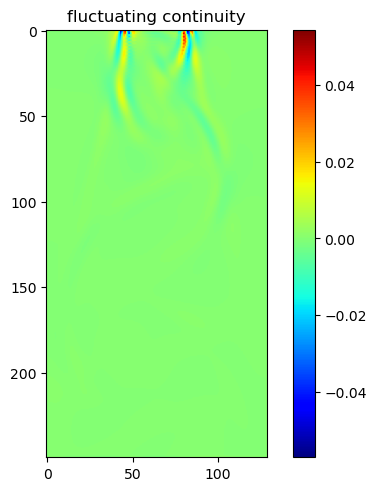

In [7]:
duf_dx1 = derivative1(x_fluc[:,0,:,:],dx,axis=1)
dvf_dx2 = derivative1(x_fluc[:,1,:,:],dy,axis=2)
fluc_div = duf_dx1 + dvf_dx2
print(losses.mse(fluc_div))
plt.figure()
plt.title('fluctuating continuity')
plt.imshow(fluc_div[10,...])
plt.colorbar()
plt.show()


RANS momentum

In [8]:
x_fluc.shape

(800, 3, 250, 129)

In [9]:
rs_uu = x_fluc[:,0,:,:]**2
rs_uv = x_fluc[:,0,:,:]*x_fluc[:,1,:,:]
rs_vv = x_fluc[:,1,:,:]**2

In [10]:
dum_dx = derivatives.derivative1(x_mean[0,:,:],dx,axis=0)
um_dum_dx = x_mean[0,...]*dum_dx
dum_dy = derivatives.derivative1(x_mean[0,:,:],dy,axis=1)
vm_dum_dy = x_mean[1,...]*dum_dy

dpm_dx = derivatives.derivative1(x_mean[2,...],dx,axis=0)

d2um_dx2 = derivatives.derivative2(x_mean[0,...],dx,axis=0)
d2um_dy2 = derivatives.derivative2(x_mean[0,...],dy,axis=1)

druu_dx = derivatives.derivative1(np.mean(rs_uu,axis=0),dx,axis=0)
druv_dy = derivatives.derivative1(np.mean(rs_uv,axis=0),dy,axis=1)

0.023381103


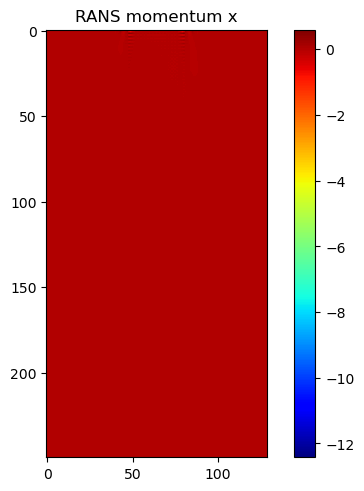

In [11]:
rans_x = um_dum_dx + vm_dum_dy + dpm_dx - (d2um_dx2 + d2um_dy2)/re + (druu_dx + druv_dy)
print(losses.mse(rans_x))
plt.figure()
plt.title('RANS momentum x')
plt.imshow(rans_x)
plt.colorbar()
plt.show()

In [12]:
dvm_dx = derivatives.derivative1(x_mean[1,:,:],dx,axis=0)
um_dvm_dx = x_mean[0,...]*dvm_dx
dvm_dy = derivatives.derivative1(x_mean[1,:,:],dy,axis=1)
vm_dvm_dy = x_mean[1,...]*dvm_dy

dpm_dy = derivatives.derivative1(x_mean[2,...],dy,axis=1)

d2vm_dx2 = derivatives.derivative2(x_mean[1,...],dx,axis=0)
d2vm_dy2 = derivatives.derivative2(x_mean[1,...],dy,axis=1)

druv_dx = derivatives.derivative1(np.mean(rs_uv,axis=0),dx,axis=0)
drvv_dy = derivatives.derivative1(np.mean(rs_vv,axis=0),dy,axis=1)

0.00095298624


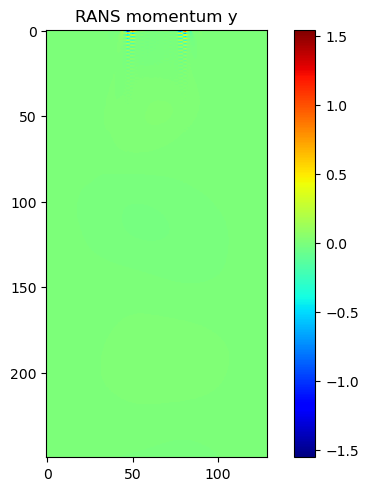

In [13]:
rans_y = um_dvm_dx + vm_dvm_dy + dpm_dy - (d2vm_dx2 + d2vm_dy2)/re + (druv_dx + drvv_dy)
print(losses.mse(rans_y))
plt.figure()
plt.title('RANS momentum y')
plt.imshow(rans_y)
plt.colorbar()
plt.show()

In [14]:
rans_mom_residual = losses.mse(rans_x) + losses.mse(rans_y)
print('RANS momentum residual  ',rans_mom_residual)
print('RANS continuity residual  ',losses.mse(rans_div))

RANS momentum residual   0.02433409
RANS continuity residual   2.8011194e-05


# Noisy

In [15]:
from flowrec.data import get_whitenoise_std
loss_and_batch = []

In [16]:
x_batch = x[:,:,:,:]
signal_noise_ratio = 20

In [17]:
std_data = np.std(x_batch,(1,2,3))
std_n = get_whitenoise_std(signal_noise_ratio,std_data)
noise_ux = np.random.normal(scale=std_n[0],size=x_batch[0,...].shape)
noise_uy = np.random.normal(scale=std_n[1],size=x_batch[1,...].shape)
noise_pp = np.random.normal(scale=std_n[2],size=x_batch[2,...].shape)
noise = np.stack([noise_ux,noise_uy,noise_pp],axis=0)
x_noisy = x_batch + noise

In [18]:
x_n_mean = np.mean(x_noisy,axis=1)
x_n_fluc = np.swapaxes(x_noisy,0,1) - x_n_mean
print(np.allclose(x_n_mean+x_n_fluc,np.swapaxes(x_noisy,0,1)))
print(x_n_mean.shape, x_n_fluc.shape)

True
(3, 250, 129) (800, 3, 250, 129)


Does mean of noisy data approximate true data? mse  1.8992837e-06


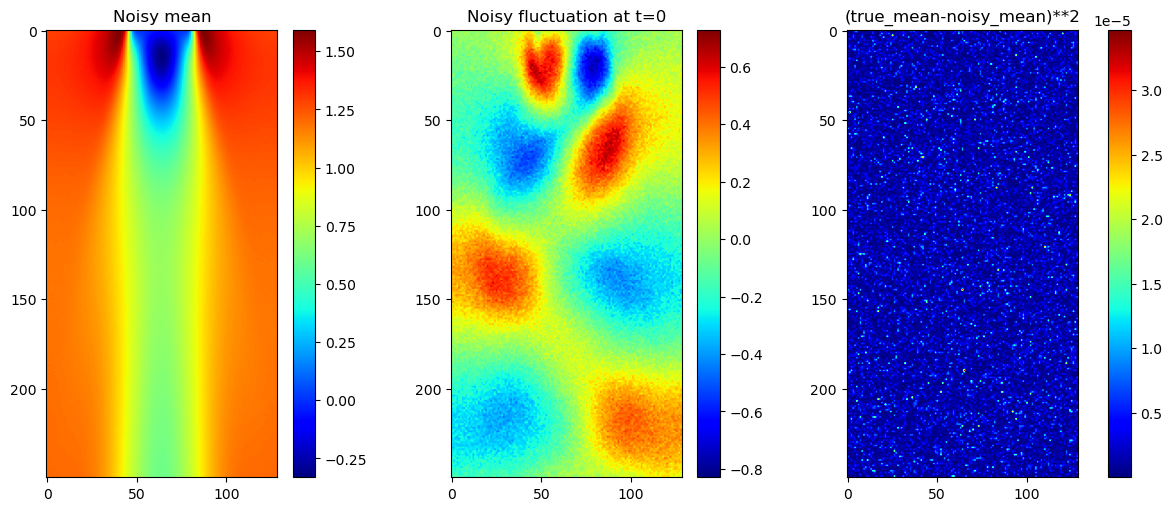

In [19]:
print('Does mean of noisy data approximate true data? mse ', losses.mse(x_n_mean,x_mean))
fig,axes = plt.subplots(1,3,figsize=(12,5))
im = axes[0].imshow(x_n_mean[0,...])
plt.colorbar(im,ax=axes[0])
axes[0].set_title('Noisy mean')
im = axes[1].imshow(x_n_fluc[0,0,...])
plt.colorbar(im,ax=axes[1])
axes[1].set_title('Noisy fluctuation at t=0')
im = axes[2].imshow(((x_mean - x_n_mean)**2)[0,...])
plt.colorbar(im,ax=axes[2])
axes[2].set_title('(true_mean-noisy_mean)**2')
plt.show()

## test 1 (p32)

In [ ]:
ds1m_dx1 = derivative1(x_n_mean[0,:,:],dx,axis=0)
ds2m_dx2 = derivative1(x_n_mean[1,:,:],dy,axis=1)
rans_div_noisy = ds1m_dx1 + ds2m_dx2
print(losses.mse(rans_div_noisy))
plt.figure()
plt.title('noisy RANS continuity')
plt.imshow(rans_div_noisy)
plt.colorbar()
plt.show()


In [ ]:
ds1m_dx = derivative1(x_n_mean[0,:,:],dx,axis=0)
s1m_ds1m_dx = x_n_mean[0,...]*ds1m_dx
ds1m_dy = derivative1(x_n_mean[0,:,:],dy,axis=1)
s2m_ds1m_dy = x_n_mean[1,...]*ds1m_dy

dpsim_dx = derivative1(x_n_mean[2,...],dx,axis=0)

d2s1m_dx2 = derivative2(x_n_mean[0,...],dx,axis=0)
d2s1m_dy2 = derivative2(x_n_mean[0,...],dy,axis=1)

druu_dx = derivative1(np.mean(rs_uu,axis=0),dx,axis=0)
druv_dy = derivative1(np.mean(rs_uv,axis=0),dy,axis=1)

In [ ]:
rans_x_noisy = s1m_ds1m_dx + s2m_ds1m_dy + dpsim_dx - (d2s1m_dx2 + d2s1m_dy2)/re + (druu_dx + druv_dy)
print(losses.mse(rans_x_noisy))
plt.figure()
plt.title('noisy RANS momentum x')
plt.imshow(rans_x_noisy)
plt.colorbar()
plt.show()

In [ ]:
ds2m_dx = derivatives.derivative1(x_n_mean[1,:,:],dx,axis=0)
s1m_ds2m_dx = x_n_mean[0,...]*ds2m_dx
ds2m_dy = derivatives.derivative1(x_n_mean[1,:,:],dy,axis=1)
s2m_ds2m_dy = x_n_mean[1,...]*ds2m_dy

dpsim_dy = derivatives.derivative1(x_n_mean[2,...],dy,axis=1)

d2s2m_dx2 = derivatives.derivative2(x_n_mean[1,...],dx,axis=0)
d2s2m_dy2 = derivatives.derivative2(x_n_mean[1,...],dy,axis=1)

druv_dx = derivatives.derivative1(np.mean(rs_uv,axis=0),dx,axis=0)
drvv_dy = derivatives.derivative1(np.mean(rs_vv,axis=0),dy,axis=1)

In [ ]:
rans_y_noisy = s1m_ds2m_dx + s2m_ds2m_dy + dpsim_dy - (d2s2m_dx2 + d2s2m_dy2)/re + (druv_dx + drvv_dy)
print(losses.mse(rans_y_noisy))
plt.figure()
plt.title('noisy RANS momentum y')
plt.imshow(rans_y_noisy)
plt.colorbar()
plt.show()

In [ ]:
rans_mom_residual_noisy = losses.mse(rans_x_noisy) + losses.mse(rans_y_noisy)
print('Noisy-with-true-fluctuation RANS momentum residual  ',rans_mom_residual_noisy)
print('Noisy RANS continuity residual  ',losses.mse(rans_div_noisy))

In [ ]:
# batch_size = [50,100,200,300,400,500,600,700,800]
# loss_and_batch.append([rans_mom_residual_noisy,losses.mse(rans_div_noisy)])

In [ ]:
# plt.figure()
# plt.plot(batch_size,loss_and_batch[:,0],'-o',label='Momentum residual')
# plt.plot(batch_size,loss_and_batch[:,1],'-o',label='Continuity')
# plt.legend()
# plt.title('Noisy RANS loss changing with batch size.')
# plt.xlabel('Batch size')
# plt.ylabel('MSE loss')
# plt.show()

## test 2 (p34)

In [ ]:
rs_s1s1 = x_n_fluc[:,0,:,:]**2
rs_s1s2 = x_n_fluc[:,0,:,:]*x_n_fluc[:,1,:,:]
rs_s2s2 = x_n_fluc[:,1,:,:]**2

In [ ]:
ds1m_dx = derivative1(x_n_mean[0,:,:],dx,axis=0)
s1m_ds1m_dx = x_n_mean[0,...]*ds1m_dx
ds1m_dy = derivative1(x_n_mean[0,:,:],dy,axis=1)
s2m_ds1m_dy = x_n_mean[1,...]*ds1m_dy

dpsim_dx = derivative1(x_n_mean[2,...],dx,axis=0)

d2s1m_dx2 = derivative2(x_n_mean[0,...],dx,axis=0)
d2s1m_dy2 = derivative2(x_n_mean[0,...],dy,axis=1)

drs1s1_dx = derivative1(np.mean(rs_s1s1,axis=0),dx,axis=0)
drs1s2_dy = derivative1(np.mean(rs_s1s2,axis=0),dy,axis=1)

In [ ]:
rans_x_allnoisy = s1m_ds1m_dx + s2m_ds1m_dy + dpsim_dx - (d2s1m_dx2 + d2s1m_dy2)/re + (drs1s1_dx + drs1s2_dy)
print(losses.mse(rans_x_allnoisy))
plt.figure()
plt.title('all noisy RANS momentum x')
plt.imshow(rans_x_allnoisy)
plt.colorbar()
plt.show()

In [ ]:
ds2m_dx = derivatives.derivative1(x_n_mean[1,:,:],dx,axis=0)
s1m_ds2m_dx = x_n_mean[0,...]*ds2m_dx
ds2m_dy = derivatives.derivative1(x_n_mean[1,:,:],dy,axis=1)
s2m_ds2m_dy = x_n_mean[1,...]*ds2m_dy

dpsim_dy = derivatives.derivative1(x_n_mean[2,...],dy,axis=1)

d2s2m_dx2 = derivatives.derivative2(x_n_mean[1,...],dx,axis=0)
d2s2m_dy2 = derivatives.derivative2(x_n_mean[1,...],dy,axis=1)

drs1s2_dx = derivatives.derivative1(np.mean(rs_s1s2,axis=0),dx,axis=0)
drs2s2_dy = derivatives.derivative1(np.mean(rs_s2s2,axis=0),dy,axis=1)

In [ ]:
rans_y_allnoisy = s1m_ds2m_dx + s2m_ds2m_dy + dpsim_dy - (d2s2m_dx2 + d2s2m_dy2)/re + (drs1s2_dx + drs2s2_dy)
print(losses.mse(rans_y_allnoisy))
plt.figure()
plt.title('allnoisy RANS momentum y')
plt.imshow(rans_y_noisy)
plt.colorbar()
plt.show()

In [ ]:
rans_mom_residual_allnoisy = losses.mse(rans_x_allnoisy) + losses.mse(rans_y_allnoisy)
print('Noisy-with-noisy-fluctuation RANS momentum residual  ',rans_mom_residual_allnoisy)
print('Noisy RANS continuity residual  ',losses.mse(rans_div_noisy))

In [ ]:
x_n_fluc.shape

In [ ]:
ds1f_dx1 = derivative1(x_n_fluc[:,0,:,:],dx,axis=1)
ds2f_dx2 = derivative1(x_n_fluc[:,1,:,:],dy,axis=2)
fluc_div_noisy = ds1f_dx1 + ds2f_dx2
print(losses.mse(fluc_div_noisy))
plt.figure()
plt.title('noisy fluctuating continuity')
plt.imshow(fluc_div_noisy[10,...])
plt.colorbar()
plt.show()


# Noisy mixed with clean

In [36]:
batch_size = 200
x_mean_r = np.copy(x_mean)
x_n_mean_batch = np.mean(x_noisy[:,:batch_size,:,:],axis=1)
x_mean_r[:,::10,::10] = x_n_mean_batch[:,::10,::10]

0.0015622488


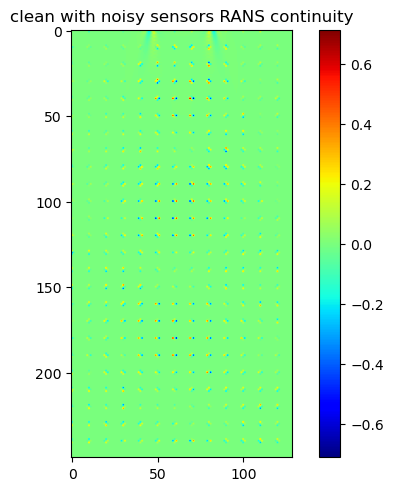

In [37]:
ds1m_dx1_r = derivative1(x_mean_r[0,:,:],dx,axis=0)
ds2m_dx2_r = derivative1(x_mean_r[1,:,:],dy,axis=1)
rans_div_noisy_r = ds1m_dx1_r + ds2m_dx2_r
print(losses.mse(rans_div_noisy_r))
plt.figure()
plt.title('clean with noisy sensors RANS continuity')
plt.imshow(rans_div_noisy_r)
plt.colorbar()
plt.show()


In [38]:
ds1m_dx_r = derivative1(x_mean_r[0,:,:],dx,axis=0)
s1m_ds1m_dx_r = x_mean_r[0,...]*ds1m_dx_r
ds1m_dy_r = derivative1(x_mean_r[0,:,:],dy,axis=1)
s2m_ds1m_dy_r = x_mean_r[1,...]*ds1m_dy_r

dpsim_dx_r = derivative1(x_mean_r[2,...],dx,axis=0)

d2s1m_dx_r2 = derivative2(x_mean_r[0,...],dx,axis=0)
d2s1m_dy_r2 = derivative2(x_mean_r[0,...],dy,axis=1)

druu_dx_r = derivative1(np.mean(rs_uu,axis=0),dx,axis=0)
druv_dy_r = derivative1(np.mean(rs_uv,axis=0),dy,axis=1)

0.026345551


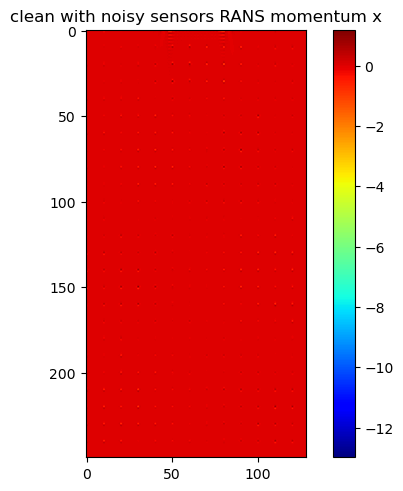

In [39]:
rans_x_noisy_r = s1m_ds1m_dx_r + s2m_ds1m_dy_r + dpsim_dx_r - (d2s1m_dx_r2 + d2s1m_dy_r2)/re + (druu_dx_r + druv_dy_r)
print(losses.mse(rans_x_noisy_r))
plt.figure()
plt.title('clean with noisy sensors RANS momentum x')
plt.imshow(rans_x_noisy_r)
plt.colorbar()
plt.show()

In [40]:
ds2m_dx_r = derivatives.derivative1(x_mean_r[1,:,:],dx,axis=0)
s1m_ds2m_dx_r = x_mean_r[0,...]*ds2m_dx_r
ds2m_dy_r = derivatives.derivative1(x_mean_r[1,:,:],dy,axis=1)
s2m_ds2m_dy_r = x_mean_r[1,...]*ds2m_dy_r

dpsim_dy_r = derivatives.derivative1(x_mean_r[2,...],dy,axis=1)

d2s2m_dx_r2 = derivatives.derivative2(x_mean_r[1,...],dx,axis=0)
d2s2m_dy_r2 = derivatives.derivative2(x_mean_r[1,...],dy,axis=1)

druv_dx_r = derivatives.derivative1(np.mean(rs_uv,axis=0),dx,axis=0)
drvv_dy_r = derivatives.derivative1(np.mean(rs_vv,axis=0),dy,axis=1)

0.009836196


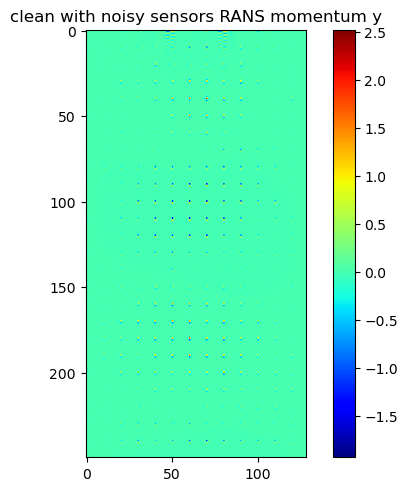

In [41]:
rans_y_noisy_r = s1m_ds2m_dx_r + s2m_ds2m_dy_r + dpsim_dy_r - (d2s2m_dx_r2 + d2s2m_dy_r2)/re + (druv_dx_r + drvv_dy_r)
print(losses.mse(rans_y_noisy_r))
plt.figure()
plt.title('clean with noisy sensors RANS momentum y')
plt.imshow(rans_y_noisy_r)
plt.colorbar()
plt.show()

In [42]:
rans_mom_residual_noisy_r = losses.mse(rans_x_noisy_r) + losses.mse(rans_y_noisy_r)
print('Noisy sensor in clean data with true fluctuation RANS momentum residual  ',rans_mom_residual_noisy_r)
print('Noisy sensor in clean data RANS continuity residual  ',losses.mse(rans_div_noisy_r))

Noisy sensor in clean data with true fluctuation RANS momentum residual   0.036181748
Noisy sensor in clean data RANS continuity residual   0.0015622488


## Effect of batch size

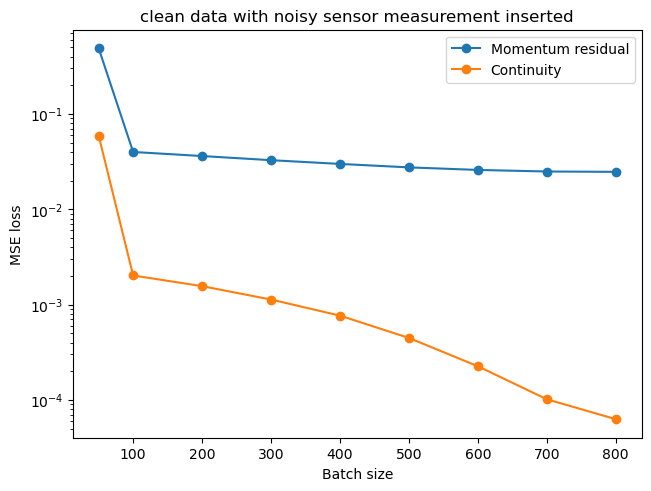

In [52]:
batches = [50,100,200,300,400,500,600,700,800]
loss_continuity_batch = []
loss_momentum_batch = []
for batch_size in batches:
    tmp_x_mean_r = np.copy(x_mean)
    tmp_x_n_mean_batch = np.mean(x_noisy[:,:batch_size,:,:],axis=1)
    tmp_x_mean_r[:,::10,::10] = tmp_x_n_mean_batch[:,::10,::10]

    tmp_ds1m_dx1_r = derivative1(tmp_x_mean_r[0,:,:],dx,axis=0)
    tmp_ds2m_dx2_r = derivative1(tmp_x_mean_r[1,:,:],dy,axis=1)
    tmp_rans_div_noisy_r = tmp_ds1m_dx1_r + tmp_ds2m_dx2_r
    loss_continuity_batch.append(losses.mse(tmp_rans_div_noisy_r))


    tmp_ds1m_dx_r = derivative1(tmp_x_mean_r[0,:,:],dx,axis=0)
    tmp_s1m_ds1m_dx_r = tmp_x_mean_r[0,...]*tmp_ds1m_dx_r
    tmp_ds1m_dy_r = derivative1(tmp_x_mean_r[0,:,:],dy,axis=1)
    tmp_s2m_ds1m_dy_r = tmp_x_mean_r[1,...]*tmp_ds1m_dy_r
    tmp_dpsim_dx_r = derivative1(tmp_x_mean_r[2,...],dx,axis=0)
    tmp_d2s1m_dx_r2 = derivative2(tmp_x_mean_r[0,...],dx,axis=0)
    tmp_d2s1m_dy_r2 = derivative2(tmp_x_mean_r[0,...],dy,axis=1)
    tmp_druu_dx_r = derivative1(np.mean(rs_uu,axis=0),dx,axis=0)
    tmp_druv_dy_r = derivative1(np.mean(rs_uv,axis=0),dy,axis=1)
    tmp_rans_x_noisy_r = tmp_s1m_ds1m_dx_r + tmp_s2m_ds1m_dy_r + tmp_dpsim_dx_r - (tmp_d2s1m_dx_r2 + tmp_d2s1m_dy_r2)/re + (tmp_druu_dx_r + tmp_druv_dy_r)

    tmp_ds2m_dx_r = derivatives.derivative1(tmp_x_mean_r[1,:,:],dx,axis=0)
    tmp_s1m_ds2m_dx_r = tmp_x_mean_r[0,...]*tmp_ds2m_dx_r
    tmp_ds2m_dy_r = derivatives.derivative1(tmp_x_mean_r[1,:,:],dy,axis=1)
    tmp_s2m_ds2m_dy_r = tmp_x_mean_r[1,...]*tmp_ds2m_dy_r
    tmp_dpsim_dy_r = derivatives.derivative1(tmp_x_mean_r[2,...],dy,axis=1)
    tmp_d2s2m_dx_r2 = derivatives.derivative2(tmp_x_mean_r[1,...],dx,axis=0)
    tmp_d2s2m_dy_r2 = derivatives.derivative2(tmp_x_mean_r[1,...],dy,axis=1)
    tmp_druv_dx_r = derivatives.derivative1(np.mean(rs_uv,axis=0),dx,axis=0)
    tmp_drvv_dy_r = derivatives.derivative1(np.mean(rs_vv,axis=0),dy,axis=1)
    tmp_rans_y_noisy_r = tmp_s1m_ds2m_dx_r + tmp_s2m_ds2m_dy_r + tmp_dpsim_dy_r - (tmp_d2s2m_dx_r2 + tmp_d2s2m_dy_r2)/re + (tmp_druv_dx_r + tmp_drvv_dy_r)

    tmp_rans_mom_residual_noisy_r = losses.mse(tmp_rans_x_noisy_r) + losses.mse(tmp_rans_y_noisy_r)

    loss_momentum_batch.append(tmp_rans_mom_residual_noisy_r)

plt.figure()
plt.title('clean data with noisy sensor measurement inserted')
plt.xlabel('Batch size')
plt.ylabel('MSE loss')
plt.plot(batches,np.array(loss_momentum_batch),'o-',label='Momentum residual')
plt.plot(batches,np.array(loss_continuity_batch),'-o',label='Continuity')
plt.yscale('log')
plt.legend()
plt.show()